# Part I: Federated Learning in a Nutshell

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leolavaur/icdcs_2025/blob/main/notebooks/part1.ipynb)

In this first part, we will go over the basic concepts of experimenting with federated learning (FL), using the Flower framework, and TensorFlow as the machine learning (ML) backend.
We will see how we can leverage Flower's simulation capabilities to run a horizontal FL experiment in cross-device setting, using the MNIST dataset and a simple convolutional model.

## Section 0: Prerequisites

### Dependencies

> Be advised that Google collab currently does not support the latest versions of Python (limited to 3.11.13).
> The present notebook has been designed to work with Python 3.11, and may not work with earlier or later versions.
> Please ensure that you have the correct Python version.

If you are running this notebook in Google Colab, you can install the required dependencies by running the following cell. Otherwise, you can install them in your local environment using `uv` or `pip`.

In [ ]:
%load_ext autoreload
%autoreload 2

from IPython.core.getipython import get_ipython

if "google.colab" in str(get_ipython()):
    !git clone https://github.com/leolavaur/icdcs_2025
    %pip install -r icdcs_2025/requirements.txt


Once you have a working environment, check that everything works, notably your GPU for the TensorFlow backend.
You can do so by running the following cell:

In [2]:
import tensorflow as tf
from IPython.utils import io

with io.capture_output(stdout=False) as _:
    print("TensorFlow version:", tf.__version__)
    print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

2025-07-19 19:21:38.564634: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 19:21:38.577930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752945698.592989   69827 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752945698.597556   69827 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752945698.608973   69827 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
Num GPUs Available: 0


2025-07-19 19:21:41.266919: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


To allow others to reproduce your results with some degree of certitude, set a seed for all the pseudo-random number generators (PRNG) that you use.
You should also run your threads deterministically, in case your ML backend optimize training.
This will have a negative impact on the performance.
On TensorFlow: 

In [ ]:
import keras

keras.utils.set_random_seed(1138)

### Section 1: Data exploration and partitioning

MNIST is a basic datasets often use as an easy benchmark for computer-vision algorithms.
It contains 28x38 grayscale pictures of handwritten digits (from 0 to 9).
One typical task is to classify each digit to its corresponding class.

The dataset is bundled in a lot of ML frameworks, including TensorFlow.
However, Huggingface's user-friendly `datasets` library provides a more convenient way to load it.
It is also well-integrated with Flower, which we will use later on.
Let's load the dataset and explore it a bit.

In [4]:
from typing import cast

from datasets import DatasetDict, load_dataset

ds = cast(DatasetDict, load_dataset("ylecun/mnist"))
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

Let's look at some samples from the dataset.

In [5]:
import matplotlib.pyplot as plt

trainset = ds["train"]
example = trainset[0]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 5}

In [6]:
example["image"]

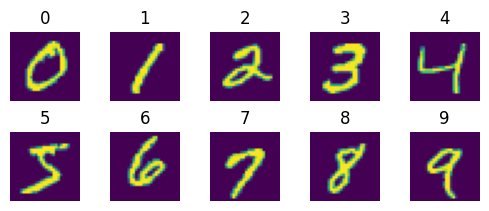

In [7]:
import numpy as np
from matplotlib.axes import Axes

fig, axs = plt.subplots(2, 5, figsize=(5, 2), constrained_layout=True)
assert isinstance(axs, np.ndarray)
for i, ax in enumerate(axs.flatten()):
    ax: Axes
    ex = next((ex for ex in trainset if ex["label"] == i))
    ax.imshow(ex["image"])
    ax.axis("off")
    ax.set_title(str(i))

The dataset associates each image with a label, which is the digit it represents, from 0 to 9.
Deep learning models can be trained to predict these labels from the images, as a list of integers.
However, it might be more interesting to train a model that can give a probability distribution over the classes, which is more informative.

To do so, we commonly rely on one-hot encoding, where each label is represented as a vector of zeros, except for the index corresponding to the label, which is set to 1.
Additionally, we will normalize the images to have pixel values between 0 and 1, which typically improves the training of deep learning models.

In [8]:
import numpy as np
from datasets import Array2D, ClassLabel, Sequence, Value
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories=[list(range(10))])


def preprocess(example):
    example["pixels"] = np.array(example["image"]) / 255.0
    example["onehot_label"] = np.zeros(10, dtype=np.float32)
    example["onehot_label"][example["label"]] = 1.0

    return example


new_features = ds["train"].features.copy()
new_features["pixels"] = Array2D(shape=(28, 28), dtype="float32")
new_features["onehot_label"] = Sequence(feature=Value(dtype="float32"), length=10)
ds = ds.map(preprocess, num_proc=4).cast(new_features)

In [9]:
ds["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], id=None),
 'pixels': Array2D(shape=(28, 28), dtype='float32', id=None),
 'onehot_label': Sequence(feature=Value(dtype='float32', id=None), length=10, id=None)}

In [10]:
ds["train"][0]["onehot_label"]

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

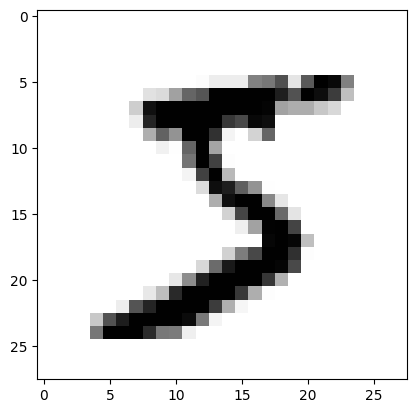

In [11]:
plt.imshow(ds["train"][0]["pixels"], cmap="gray_r")

Training a model means finding the best parameters for it, so that it can correctly classify the
data. This is done by minimizing a loss function, which is a measure of how well the model performs
on the training data. The loss function is computed on the training data, and the model is updated
to minimize it. This process is repeated until the loss function converges to a local minimum.

MNIST is an "easy" problem, with low-dimensional images and a small number of classes. A simple deep-learning model architecture suffices to obtain relevant results.

In [12]:
def mk_model(lr=0.001) -> keras.Model:
    """Create a simple DNN model for MNIST classification."""
    model = keras.models.Sequential(
        [
            keras.layers.Input(shape=(28, 28)),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(10, activation="softmax"),
        ]
    )
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    return model


mk_model().summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

We will use the `fit` method of the Keras model to train it over a few epochs.
We can also play around with the batch size, which defines how frequently the model is updated.


Note: a smaller batch size will result in more steps per epoch, and therefore a longer training time. 

We use the TensorFlow backend to train the model, and therefore rely on TensorFlow's data loading and preprocessing utilities. The `to_dataset` method of 🤗 converts the `Dataset` instance into a TensorFlow *prefetched* dataset, which offers great performance.

In [13]:
import math

if len(tf.config.list_physical_devices("GPU")) > 0:
    scaling_fact = 8  # A GPU can usually handle much larger batches
else:
    scaling_fact = 1.0

BATCH_SIZE = int(256 * scaling_fact)
LEANRING_RATE = 0.01 * math.sqrt(scaling_fact)  # scale lr by sqrt(batch size ratio)
EPOCHS = 5

trainset = ds["train"].to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

testset = ds["test"].to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

model = mk_model(lr=LEANRING_RATE)
hist = model.fit(trainset, epochs=EPOCHS)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.8543 - loss: 0.4639
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9517 - loss: 0.1611
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9596 - loss: 0.1304
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9661 - loss: 0.1096
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9693 - loss: 0.0973


In [14]:
model.evaluate(testset)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9647 - loss: 0.1241


[0.10197550803422928, 0.9708999991416931]

## Section 2: Local training

To train a federation of devices one needs to partition the dataset into multiple subsets, one for each device. Partitions are sometimes referred to as shards, one shard of the training set per client.

For research purposes, as we have the entire dataset, we can use one testing set to evaluate the performance of the model. In a real-world scenario, we would not have access to the testing set, and each client would have to evaluate the model on its own data.

In [15]:
from flwr_datasets.partitioner import IidPartitioner

NUM_CLIENTS = 10

partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)
partitioner.dataset = ds["train"]

train_0 = partitioner.load_partition(0)
train_0

Dataset({
    features: ['image', 'label', 'pixels', 'onehot_label'],
    num_rows: 6000
})

Flower, the FL framework leveraged in this example also provides a utility to partition the dataset into shards, using Huggingface's `datasets` library.
We can use it to visualize the distribution of the data across the clients.

A first example is IID partitioning, where the data is distributed uniformly across the clients.
This means that each shard contains a similar data distribution.

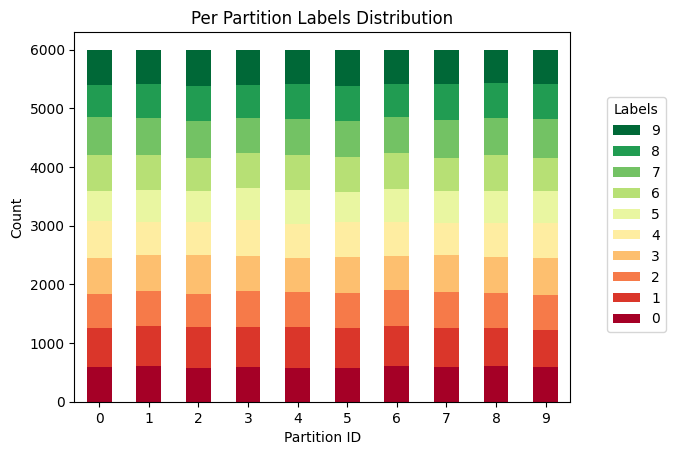

In [16]:
from flwr_datasets.visualization import plot_label_distributions

_ = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
)

The `flwr_dataset` library also provides other partitioning strategies, to simulate non-IID data distribution.
Some examples include:

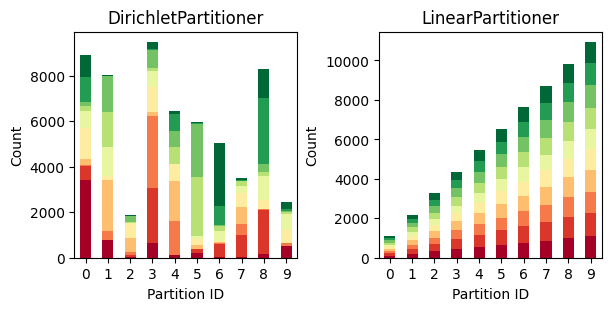

In [17]:
from flwr_datasets.partitioner import DirichletPartitioner, LinearPartitioner

fig = plt.figure(figsize=(6, 3), constrained_layout=True)
axs = fig.subplots(1, 2)

partitioner = DirichletPartitioner(
    num_partitions=NUM_CLIENTS, partition_by="label", alpha=0.5
)
partitioner.dataset = ds["train"]
_ = plot_label_distributions(
    partitioner, label_name="label", axis=axs[0], title="DirichletPartitioner"
)

partitioner = LinearPartitioner(num_partitions=NUM_CLIENTS)
partitioner.dataset = ds["train"]
_ = plot_label_distributions(
    partitioner, label_name="label", axis=axs[1], title="LinearPartitioner"
)

Let's test training a model on a single client, to see how well it performs on the training data.

In [18]:
# Model / data parameters

NUM_CLIENTS = 100

partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)
partitioner.dataset = ds["train"]

train_0 = partitioner.load_partition(0)
train_0

Dataset({
    features: ['image', 'label', 'pixels', 'onehot_label'],
    num_rows: 600
})

Increasing the number of clients will logically reduce the number of samples per client.

In [19]:
EPOCHS = 10

train_0 = train_0.to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

model = mk_model()
hist = model.fit(train_0, epochs=EPOCHS)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1310 - loss: 2.3210 
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4800 - loss: 1.9043
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6759 - loss: 1.5803
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7666 - loss: 1.3167
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7924 - loss: 1.0933
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8022 - loss: 0.9302
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8271 - loss: 0.7822
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8496 - loss: 0.6795
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8412 - loss: 0.6153
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8718 - loss: 0.5425


In [20]:
testset = ds["test"].to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

loss, accuracy = model.evaluate(testset)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7714 - loss: 0.7754
Test loss: 0.6797357201576233
Test accuracy: 0.8070999979972839


## Part 3: Federated learning

We use Flower to train our federated model.
In federated learning, the model is trained on multiple clients, which are usually distributed across the network.
Each client has a local dataset, and the model is trained on it.
The model is then sent to the server, which aggregates the updates and sends them back to the clients.

The clients then apply the updates to their local model, and the process is repeated.
We call this cycle a round.

The `flwr` library is a Python implementation of FL.
It provides a set of tools to implement a
federated learning in simulations, as well as in real-world applications.
It is designed to be easy
to use, and to be compatible with a wide range of ML frameworks, including Tensorflow/Keras.

Its main components are:
- `flwr.client`: contains the `Client` class, which represents a client in the FL process.
  It provides a set of methods that are called by the server during the training process.
  The client can be simulated using `ray`, or run on a real device.
- `flwr.server`: contains the `Server` class, which represents the server in the FL process.
  It acts as a coordinator, and is responsible for managing the training process.
- `flwr.strategy`: contains the implementation of the aggregation algorithm.
  `FedAvg` is the most common algorithm, and is the one we will use in this tutorial, but `flwr` also provides other strategies, such as `FedProx`, `FedOpt`, `FedYogi`, `FedAdagrad`, and `FedAdam`.



The latest versions of Flower have focused on unifying the API around the `ClientApp` and `ServerApp` classes, which are now the main entry points for running a federated learning experiment.
This is true for both simulation and real-world applications deployments.

Below is a diagram of `flwr`'s architecture, you can find more information in the [documentation](https://flower.dev/docs/architecture.html).

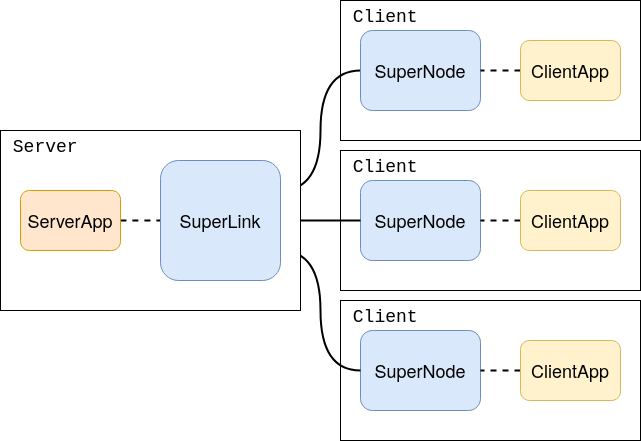

The `ClientApp` is a wrapper around the `Client` class, which provides a simple interface to run training and evaluation on a local dataset.
The Flower client offers two main methods:
- `fit()`: trains the model for the specified number of epochs, using the local dataset. The method
  returns the model parameters, the number of samples used for training, and the training loss.
- `evaluate()`: evaluates the model on the local dataset, and returns the evaluation metrics. 

In [ ]:
import flwr as fl
import tensorflow as tf


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainset: tf.data.Dataset):
        keras.utils.set_random_seed(1138)  # In client thread
        self.model = mk_model()
        self.trainset = trainset

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.trainset, epochs=1, verbose=0)
        return self.model.get_weights(), len(self.trainset), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.trainset, verbose=0)
        return loss, len(self.trainset), {"accuracy": accuracy}

Let's write a function that will create client instances for us, using a Flower partitioner.

In [22]:
from typing import Callable

from flwr.client import Client, ClientApp
from flwr.common import Context
from flwr_datasets.partitioner import Partitioner


def mk_client_fn(
    partitioner: Partitioner,
) -> Callable[[str], Client]:
    """Return a function which creates a new Client for a given partition."""

    def client_fn(context: Context) -> Client:
        """Create a new Client for partition i."""
        partition_id = int(context.node_config["partition-id"])
        client_dataset = partitioner.load_partition(partition_id)
        client_dataset = client_dataset.to_tf_dataset(
            columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
        )
        return FlowerClient(trainset=client_dataset).to_client()

    return client_fn


client_fn = mk_client_fn(partitioner)
client_app = ClientApp(client_fn=client_fn)

We can write other helper functions to facilitate metric collection and parameter evaluation.

In [ ]:
def get_evaluate_fn(testset):
    """Return an evaluation function for server-side evaluation with an history."""
    history: list[dict[str, float]] = []

    # The `evaluate` function will be called after every round by the strategy
    def evaluate_fn(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: dict[str, fl.common.Scalar],
    ):
        model = mk_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(testset, verbose=0)

        history.append(
            {
                "round": server_round,
                "loss": loss,
                "accuracy": accuracy,
            }
        )

        return loss, {"accuracy": accuracy}

    return evaluate_fn, history

Finally, let's create the `ServerApp`, which is the main entry point for running a federated learning experiment.

In [29]:
from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.server.strategy import FedAvg, Strategy


def mk_server_fn(
    strategy: Strategy,
    num_rounds: int = 10,
) -> Callable[[Context], ServerAppComponents]:
    def server_fn(context: Context) -> ServerAppComponents:
        config = ServerConfig(num_rounds=num_rounds)
        return ServerAppComponents(
            strategy=strategy,
            config=config,
        )

    return server_fn


model = mk_model()
np_params = model.get_weights()
init_params = ndarrays_to_parameters(np_params)

testset = ds["test"].to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

evaluate_fn, history = get_evaluate_fn(testset)

strategy = FedAvg(
    fraction_fit=0.1,  # Sample 10% of available clients for training
    fraction_evaluate=0,  # Disable federated evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_available_clients=int(
        NUM_CLIENTS * 0.25
    ),  # Wait until at least 75 clients are available
    evaluate_fn=evaluate_fn,  # Global evaluation function
    initial_parameters=init_params,  # Initial model parameters
)

server_app = ServerApp(
    server_fn=mk_server_fn(
        strategy=strategy,
        num_rounds=10,
    )
)

Let's create a federated learning simulation with Flower, using the MNIST dataset and our simple model.

In [30]:
import os

from flwr.client import ClientApp
from flwr.server import ServerApp
from flwr.simulation import run_simulation
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

NUM_CLIENTS = 100

# Enable GPU growth in the main process
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "1"


# Start simulation
fl.simulation.run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config={
        "client_resources": {
            "num_cpus": 2,
            "num_gpus": 0.1 if len(tf.config.list_physical_devices("GPU")) > 0 else 0.0,
        }
    },
)


INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 2.3143577575683594, {'accuracy': 0.15809999406337738}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)
(pid=82417) 2025-07-19 19:25:14.177669: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=82422) 2025-07-19 19:25:14.168046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=82417) WARNING: All

Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

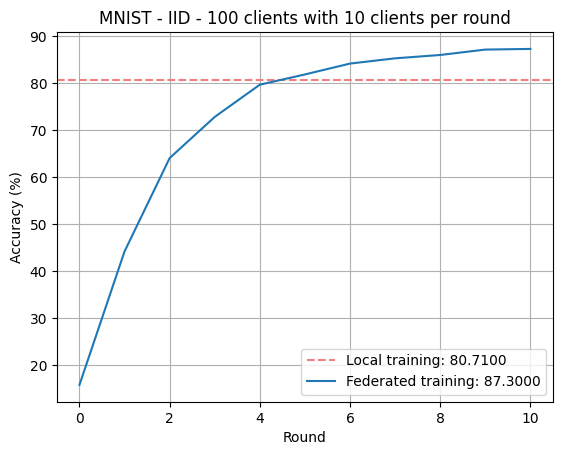

In [31]:
round = [metrics["round"] for metrics in history]
acc = [100.0 * metrics["accuracy"] for metrics in history]

local = accuracy * 100
plt.axhline(
    y=local, label=f"Local training: {local:.4f}", linestyle="--", color="lightcoral"
)
plt.plot(round, acc, label=f"Federated training: {max(acc):.4f}")
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.legend()
plt.title("MNIST - IID - 100 clients with 10 clients per round")